<hr style="border-top-width: 4px; border-top-color: #34609b;">
# Using pytimber with pandas 

Ideally the main parameters of the CERN Accelerator complex (settings and acquisitions) are stored in CALS (CERN Accelerator Logging System,https://be-dep-co.web.cern.ch/content/cals-cern-accelerator-logging-service) for long term (LDB) or short term (MDB, 3 months presently (July, 2017)).

A new CALS platform is presently under devolpment (NXCALS).

A good strategy for the MD community is to ask to complete the present logging adding additional variables if needed (typically in the MDB). In this way one does not need to setup manual logging sessions.
Each machine should have a OP-CALS link person (e.g., O. Hans for the PS).

CALS can be queried from the internet or GPN (General Purpose Network) using SWAN (Service for Web-based ANalysis, https://swan.web.cern.ch/). It is important to note that SWAN is not available (July, 2017) in the TN (Technical Network).

To log manually parameters (e.g., not already present in CALS) one can use different approaches (Matlab, Python, Mathematica, see Scripting Tool on the wikis https://wikis.cern.ch/display/ST/Scripting+Tools+Home). In addition to the logging, a similar approach can be extended to modify the machine setting (provided a valid the RBAC token if requested).

In the following we will show some example on how to use pyTIMBER together with pandas dataframe. Before doind that,  we would like to comment of the difference between cycleStamp and acquisitionStamp.

Fundamentaly CALS is logging series in the 2 columns format (times, values).
The time can be the timestamp of the cycle related to that acquisition (cycleStamp) or the acquisitionStamp.
For the Injector Complex is much more convenient to log in cycleStamp because this allows to compare quantities related to the same cycle. In general is not interesting to compare observation related to different cycles even if their acquisition stamp is very close.
In machine with very long cycle (LHC) this cycleStamp concept is not interesting anymore. In other words, we can say that the cycleStamp is useful only if the machine is intrinsecally PPM. In  PPM machines one can extract data from CALS by fundamentals filters. This feature is not very attractive for LHC.

As we will see, these observations will have a strong impact on how the pandas dataframe will be organized. For instance, if we want to extend an existing dataframe with an additional variable, this is somehow trivial for LHC, but for the other machines we should maintain syncronization to the same cycleStamps. It is important to observe that the cyclestamps between different cycle in teh same machine or between machines have fixed time offset. One could use a sort of arithmetic of the cycleStamp to follow the same beams in the different machine of the injectors complex or to investigate the effect of SC composition on the beam performance of machine.




## JAPC  and pyJAPC
This is the JAVA API for Parameters Control.
See the presentation W. Sliwinski on https://indico.cern.ch/event/404646/.

BE-CO chose to have a JAVA API for control the machine parameters. On the other hand JAVA is not very well suited for scientific computing without a major effort (at least in our opinion). Indeed MATLAB is based on JAVA but is not open source. A first succesful attempt to GET/SET/SUBSCRIBE in MATLAB was in the past within the CTF3 community (main contributor is D. Gamba). More recently a similar approach was  adopted for python (pyJAPC by T. Levens and M. Betz). In parallel R. De Maria developped pyTIMBER (to access CALS) and pyLSA (together with M. Hostettler). In addition pyLogbook was developped by S. Gessner. These tools naturally complete the JMAD package and all the python code developped in BE-ABP (pyHEADTAIL, pyECOUD,...).

We will describe in future how to use pyJAPC and pyLSA respectively to GET the CALS data, to GET/SET/SUBSCRIBE data from/to the HW (or the last settings of the LSA database), to GET the historical trims in LSA.


<hr style="border-top-width: 4px; border-top-color: #34609b;">

# Let us start



In [1]:
import sys
sys.path.append('/eos/user/s/sterbini/MD_ANALYSIS/public/')
from myToolbox import *

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-514.10.2.el7.x86_64-x86_64-with-redhat-6.7-Carbon
Your folder is /eos/user/s/sterbini/MD_ANALYSIS
Your IP is 172.17.0.2
2017-07-24 09:30:06


<hr style="border-top-width: 4px; border-top-color: #34609b;">

# Example  1
Let us assume that you start to download some raw data from CALS. Here I decided to download some  variables recorded by acqStamp and some others by cycleStamp from the S. The fundamental filtering makes sense only on the variable recorded by cycleStamp.

In [2]:
# Heavily using pyTimber we get the variable
varSet1=log.search('%TPS15%') #recorded by acqStamp since is not PPM
varSet2=log.search('CPS.TGM%')#recorded by cyclestamp
print(varSet1) # just to show what is inside
print(varSet2) # just to show what is inside

[u'PE.TPS15.359.CONTROLLER:ANGLE', u'PE.TPS15.359.CONTROLLER:DS_POS', u'PE.TPS15.359.CONTROLLER:STATE', u'PE.TPS15.359.CONTROLLER:US_POS']
[u'CPS.TGM:BATCH', u'CPS.TGM:BEAMID', u'CPS.TGM:BPNM', u'CPS.TGM:CYCLE', u'CPS.TGM:DEST', u'CPS.TGM:DEST2', u'CPS.TGM:DURN', u'CPS.TGM:HARMN', u'CPS.TGM:MISC', u'CPS.TGM:MISC_A', u'CPS.TGM:PARTY', u'CPS.TGM:SCNUM', u'CPS.TGM:SCTAG', u'CPS.TGM:SPCON', u'CPS.TGM:USER']


In [3]:
extractFromTime=myToolbox.time_1_hour_ago(hours=2)
extractToTime=myToolbox.time_1_hour_ago(hours=1)
# Heavily using PANDAS 
# we cannot use the fundamental (recorded by acqStamp)! 
myDataFrame1=myToolbox.cals2pnd(varSet1,extractFromTime,extractToTime)
# we can use the fundamental
myDataFrame2=myToolbox.cals2pnd(varSet2,extractFromTime,extractToTime,fundamental='%TOF')

In [4]:
# Now I can merge and create a postprocessing DF

rawDF=myToolbox.mergeDF(myDataFrame1,myDataFrame2)

#eventually I can define a postprocessing
def postprocess(df):
    aux=pnd.DataFrame()
    aux['PE.TPS15.359.CONTROLLER:ANGLE filled']= df['PE.TPS15.359.CONTROLLER:ANGLE'].ffill()
    aux['PE.TPS15.359.CONTROLLER:ANGLE filled, doubled']= aux['PE.TPS15.359.CONTROLLER:ANGLE filled']*2+1
    return aux;

postDF=postprocess(rawDF)

#I suggest not to merge the rawDF with the postDF, this will allow to extend the raw.

In [5]:
# starting from the original DF is trivial now to extend them. 
# It is important to note that the we have somehow to remember that the second DF needs a fundamental filter
myDataFrame1=myToolbox.cals2pnd(myDataFrame1.columns,rawDF.index[-1],
                                rawDF.index[-1]+datetime.timedelta(hours=1))
myDataFrame2=myToolbox.cals2pnd(myDataFrame2.columns,rawDF.index[-1],
                                rawDF.index[-1]+datetime.timedelta(hours=1),
                                fundamental='%TOF')

In [6]:
# and now we can iterate with the merging
aux=myToolbox.mergeDF(myDataFrame1,myDataFrame2)

# and with the concatenation
rawDF=myToolbox.concatDF(rawDF,aux)
postDF=myToolbox.concatDF(postDF,postprocess(aux))

# we suggest to maintain well separated the raw data, postprocessing functions and postprocessed data. 

In [7]:
# print the dataFrame head
rawDF.head()

,CPS.TGM:BATCH,CPS.TGM:BEAMID,CPS.TGM:BPNM,CPS.TGM:CYCLE,CPS.TGM:DEST,CPS.TGM:DEST2,CPS.TGM:DURN,CPS.TGM:HARMN,CPS.TGM:MISC,CPS.TGM:MISC_A,CPS.TGM:PARTY,CPS.TGM:SCNUM,CPS.TGM:SCTAG,CPS.TGM:SPCON,CPS.TGM:USER,PE.TPS15.359.CONTROLLER:ANGLE,PE.TPS15.359.CONTROLLER:DS_POS,PE.TPS15.359.CONTROLLER:STATE,PE.TPS15.359.CONTROLLER:US_POS
2017-07-18 09:09:59.500,0.0,44213.0,29.0,24.0,NTOF,NONE,1.0,NaN,[F_EJ16],[START_CY],PROTON,1.0,768.0,[NEW_SC],TOF,NaN,NaN,NaN,NaN
2017-07-18 09:10:03.100,0.0,44213.0,32.0,26.0,NTOF,NONE,1.0,NaN,[F_EJ16],[START_CY],PROTON,1.0,768.0,[NEW_SC],TOF,NaN,NaN,NaN,NaN
2017-07-18 09:10:07.900,0.0,44213.0,36.0,30.0,NTOF,NONE,1.0,NaN,[F_EJ16],[START_CY],PROTON,1.0,768.0,[NEW_SC],TOF,NaN,NaN,NaN,NaN
2017-07-18 09:10:24.700,0.0,44213.0,12.0,11.0,NTOF,NONE,1.0,NaN,[F_EJ16],[START_CY],PROTON,2.0,768.0,[NORMAL],TOF,NaN,NaN,NaN,NaN
2017-07-18 09:10:29.500,0.0,44213.0,16.0,14.0,NTOF,NONE,1.0,NaN,[F_EJ16],[START_CY],PROTON,2.0,768.0,[NORMAL],TOF,NaN,NaN,NaN,NaN


In [8]:
# describe the dataFrame
postDF.describe()

,PE.TPS15.359.CONTROLLER:ANGLE filled,"PE.TPS15.359.CONTROLLER:ANGLE filled, doubled"
count,332.0,332.0
mean,0.0,1.0
std,0.0,0.0
min,0.0,1.0
25%,0.0,1.0
50%,0.0,1.0
75%,0.0,1.0
max,0.0,1.0


In [9]:
# extract one column as a series
rawDF[['CPS.TGM:USER','CPS.TGM:DEST']].head()

,CPS.TGM:USER,CPS.TGM:DEST
2017-07-18 09:09:59.500,TOF,NTOF
2017-07-18 09:10:03.100,TOF,NTOF
2017-07-18 09:10:07.900,TOF,NTOF
2017-07-18 09:10:24.700,TOF,NTOF
2017-07-18 09:10:29.500,TOF,NTOF


In [10]:
# extract the fourth and fifth rows
rawDF.iloc[3:5]

,CPS.TGM:BATCH,CPS.TGM:BEAMID,CPS.TGM:BPNM,CPS.TGM:CYCLE,CPS.TGM:DEST,CPS.TGM:DEST2,CPS.TGM:DURN,CPS.TGM:HARMN,CPS.TGM:MISC,CPS.TGM:MISC_A,CPS.TGM:PARTY,CPS.TGM:SCNUM,CPS.TGM:SCTAG,CPS.TGM:SPCON,CPS.TGM:USER,PE.TPS15.359.CONTROLLER:ANGLE,PE.TPS15.359.CONTROLLER:DS_POS,PE.TPS15.359.CONTROLLER:STATE,PE.TPS15.359.CONTROLLER:US_POS
2017-07-18 09:10:24.700,0.0,44213.0,12.0,11.0,NTOF,NONE,1.0,NaN,[F_EJ16],[START_CY],PROTON,2.0,768.0,[NORMAL],TOF,NaN,NaN,NaN,NaN
2017-07-18 09:10:29.500,0.0,44213.0,16.0,14.0,NTOF,NONE,1.0,NaN,[F_EJ16],[START_CY],PROTON,2.0,768.0,[NORMAL],TOF,NaN,NaN,NaN,NaN


In [11]:
# extract between time
rawDF.between_time('14:02','14:03')

,CPS.TGM:BATCH,CPS.TGM:BEAMID,CPS.TGM:BPNM,CPS.TGM:CYCLE,CPS.TGM:DEST,CPS.TGM:DEST2,CPS.TGM:DURN,CPS.TGM:HARMN,CPS.TGM:MISC,CPS.TGM:MISC_A,CPS.TGM:PARTY,CPS.TGM:SCNUM,CPS.TGM:SCTAG,CPS.TGM:SPCON,CPS.TGM:USER,PE.TPS15.359.CONTROLLER:ANGLE,PE.TPS15.359.CONTROLLER:DS_POS,PE.TPS15.359.CONTROLLER:STATE,PE.TPS15.359.CONTROLLER:US_POS


## Summary
The pandas dateframe (DF) are a very flexible data type for postprocessing CALS data. They comes with a rich asset of methods and a very active community.
Think the DF as LEGO: play with them, merge and contatenate them. Keep well separated the raw DF (extracted from CALS), the postprocessing methods and the postrprocessed DF.
NB: numpy is of course more performant of pandas DF, but I tend to buy flexibility with performace.

<hr style="border-top-width: 4px; border-top-color: #34609b;">

# Example 2

Let us consider now another user case. We would like to extract the list of the cycles following TOF in the PS in the last 10 min. We will start extracting the TOF cycle and from that DF create a new dataframe. This is an example of cycleStamp arithmetic.

In [12]:
CPSDF=myToolbox.cals2pnd(['CPS.TGM:USER'],
                         myToolbox.time_1_hour_ago(hours=1./6.),
                         myToolbox.time_now(),fundamental='%TOF')
CPSDF.head()

,CPS.TGM:USER
2017-07-18 11:02:31.900,TOF
2017-07-18 11:02:35.500,TOF
2017-07-18 11:02:47.500,TOF
2017-07-18 11:03:05.500,TOF
2017-07-18 11:03:10.300,TOF


In [16]:
# the important method to use is indexesFromCALS
cycleAfterDF=myToolbox.indexesFromCALS(CPSDF.index+datetime.timedelta(seconds=1.2),CPSDF.columns)
cycleAfterDF.head()

,CPS.TGM:USER
2017-07-18 11:02:33.100,AD
2017-07-18 11:02:36.700,EAST2
2017-07-18 11:02:48.700,LHC1
2017-07-18 11:03:06.700,MD7
2017-07-18 11:03:11.500,EAST2


## Summary

The **indexesFromCALS** method gives a great flexibility to reshuffle CALS data. For teh moment this method is not very fast: it is cycling on the rows of the DF, in future perhaps could be improved by using a primitive from CALS.


<hr style="border-top-width: 4px; border-top-color: #34609b;">

# Example 3

Let us consider now another user case. We would like to extract the list of the cyclestamp and some basic variable from MTE cycles along the injector chains. This is an example of cycleStamp arithmetic. We have to remember that the offeset between teh C0 time of the PSB, PS and SPS is 635 ms.

In [27]:
CPSDF=myToolbox.cals2pnd(['CPS.TGM:USER','CPS.TGM:BATCH','PR.DCAFTINJ_1:INTENSITY'],myToolbox.time_1_hour_ago(hours=1./6.),myToolbox.time_now(),fundamental='%MTE%')

In [28]:
firstBatch=CPSDF['CPS.TGM:BATCH']==1
SPSDF=myToolbox.indexesFromCALS(CPSDF[firstBatch].index+datetime.timedelta(seconds=0.635), ['SPS.TGM:USER'])
PSBDF=myToolbox.indexesFromCALS(CPSDF.index-datetime.timedelta(seconds=0.635), ['PSB.TGM:USER']+log.search('%_BCT_ACC_INTENSITY'))

In [40]:
print('==================================')
print('PSB')
print(PSBDF['PSB.TGM:USER'].head(4))
print('==================================')
print('CPS')
print(CPSDF['CPS.TGM:USER'].head(4))
print('==================================')
print('SPS')
print(SPSDF['SPS.TGM:USER'].head(2))

PSB
2017-07-18 11:15:44.465    SFTPRO1
2017-07-18 11:15:45.665    SFTPRO1
2017-07-18 11:16:04.865    SFTPRO1
2017-07-18 11:16:06.065    SFTPRO1
Name: PSB.TGM:USER, dtype: object
CPS
2017-07-18 11:15:45.100    SFTPRO1
2017-07-18 11:15:46.300    SFTPRO1
2017-07-18 11:16:05.500    SFTPRO1
2017-07-18 11:16:06.700    SFTPRO1
Name: CPS.TGM:USER, dtype: object
SPS
2017-07-18 11:15:45.735    SFTPRO2
2017-07-18 11:16:06.135    SFTPRO2
Name: SPS.TGM:USER, dtype: object


In [79]:
postPSBDF=pnd.DataFrame()
# note the use of the filtering with regular expression and the sum done on the rows (axis=1)
postPSBDF['Total Intensity']=PSBDF.filter(regex='BR*').sum(axis=1)
postPSBDF.head()

,Total Intensity
2017-07-18 11:15:44.465,1561.90064
2017-07-18 11:15:45.665,1559.17852
2017-07-18 11:16:04.865,1569.70261
2017-07-18 11:16:06.065,1564.50428
2017-07-18 11:16:22.865,1598.07669


datetime.datetime(2017, 7, 18, 11, 15, 45, 99997)

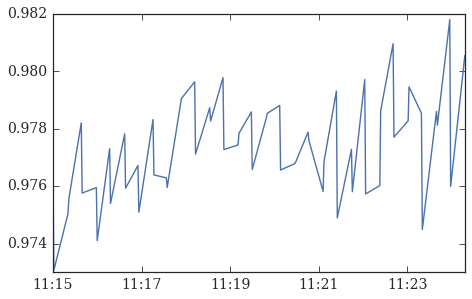

In [78]:
postCPSDF=pnd.DataFrame()
# we are now building a series using data from different DF and adopting the indexing (cycleStamp) from PS.
postCPSDF['transmission']=pnd.Series(CPSDF['PR.DCAFTINJ_1:INTENSITY'].values/postPSBDF['Total Intensity'].values,index=CPSDF.index)
plt.plot(postCPSDF['transmission'])
myToolbox.setXlabel(ax=plt.gca(), hours=1/30.)

## Summary

We have now the basic tools to monitor the beam performance across the CERN accelerator complex.


<hr style="border-top-width: 4px; border-top-color: #34609b;">

# APPENDIX A: Offset between the machines

There are 635 ms of delay between the C0 of PS and the C0 of PSB.

There are 635 ms of delay between the C0 of SPS and the C0 of PS.

See below for a verification. This allows to make an simple aritmetic before the different cycles.

In [120]:
t1=myToolbox.time_1_hour_ago(hours=.1)
t2=myToolbox.time_now()
CPS=myToolbox.cals2pnd(log.search('CPS.TGM%'),t1,t2)
PSB=myToolbox.cals2pnd(log.search('PSB.TGM%'),t1,t2)
SPS=myToolbox.cals2pnd(log.search('SPS.TGM%'),t1,t2)
SPS.head(10)

,SPS.TGM:DDEST,SPS.TGM:SCNUM,SPS.TGM:BEAMID,SPS.TGM:USER
2017-07-18 10:29:22.935,SPS_DUMP,NaN,59150.0,SFTPRO2
2017-07-18 10:29:33.735,SPS_DUMP,NaN,58568.0,LHC2
2017-07-18 10:29:40.935,SPS_DUMP,1.0,59150.0,SFTPRO2
2017-07-18 10:29:51.735,SPS_DUMP,NaN,41886.0,LHC3
2017-07-18 10:30:01.335,SPS_DUMP,NaN,59150.0,SFTPRO2
2017-07-18 10:30:12.135,SPS_DUMP,NaN,58568.0,LHC2
2017-07-18 10:30:19.335,SPS_DUMP,2.0,59150.0,SFTPRO2
2017-07-18 10:30:30.135,SPS_DUMP,NaN,41886.0,LHC3
2017-07-18 10:30:39.735,SPS_DUMP,NaN,59150.0,SFTPRO2
2017-07-18 10:30:50.535,SPS_DUMP,NaN,58568.0,LHC2


In [122]:
SCNUM=1
PSB[PSB['PSB.TGM:SCNUM']==SCNUM].head(1)

,PSB.TGM:DEST_R1,PSB.TGM:DEST_R3,PSB.TGM:DEST_R2,PSB.TGM:BPNM,PSB.TGM:DEST_R4,PSB.TGM:DEST_G,PSB.TGM:COMLN,PSB.TGM:SCNUM,PSB.TGM:DEST,PSB.TGM:HARMN,PSB.TGM:SPCON,PSB.TGM:BEAMID,PSB.TGM:SCTAG,PSB.TGM:BATCH,PSB.TGM:USER,PSB.TGM:PARTY,PSB.TGM:LIN2D
2017-07-18 10:29:39.665,SPS_DUMP,SPS_DUMP,SPS_DUMP,1.0,SPS_DUMP,SPS_DUMP,[NO_LNDMP],1.0,PS,NaN,[NEWSC],59150.0,960.0,1.0,SFTPRO1,PROTON,PSB


In [123]:
CPS[CPS['CPS.TGM:SCNUM']==SCNUM].head(1)

,CPS.TGM:MISC,CPS.TGM:CYCLE,CPS.TGM:DURN,CPS.TGM:BATCH,CPS.TGM:DEST,CPS.TGM:HARMN,CPS.TGM:SCTAG,CPS.TGM:USER,CPS.TGM:SPCON,CPS.TGM:SCNUM,CPS.TGM:BEAMID,CPS.TGM:BPNM,CPS.TGM:PARTY,CPS.TGM:MISC_A,CPS.TGM:DEST2
2017-07-18 10:29:40.300,[MT_EJ16],1.0,1.0,1.0,SPS_DUMP,NaN,960.0,SFTPRO1,[NEW_SC],1.0,59150.0,1.0,PROTON,[MDBEAM],NONE


In [124]:
SPS[SPS['SPS.TGM:SCNUM']==SCNUM]

,SPS.TGM:DDEST,SPS.TGM:SCNUM,SPS.TGM:BEAMID,SPS.TGM:USER
2017-07-18 10:29:40.935,SPS_DUMP,1.0,59150.0,SFTPRO2


In [125]:
CPS[CPS['CPS.TGM:SCNUM']==SCNUM].index[0]-PSB[PSB['PSB.TGM:SCNUM']==SCNUM].index[0]

Timedelta('0 days 00:00:00.635000')

In [126]:
SPS[SPS['SPS.TGM:SCNUM']==SCNUM].index[0]-CPS[CPS['CPS.TGM:SCNUM']==SCNUM].index[0]

Timedelta('0 days 00:00:00.635000')

<hr style="border-top-width: 4px; border-top-color: #34609b;">
# Appendix B: Retrieving data from Matlab
Not all the machine data are recorded in CALS. For getting and recording the data not present in CALS one can automatically subscribe the data with JAPC (https://wikis.cern.ch/display/ST/Libraries+Available).
I am using a lot Matlab/JAPC interface but I would like to migrate to the Python/JAPC solution.
In the following we assume you have some matlab files in a folder and you want to import them. As you will see the approach is very similar to the CALS dataframe.

In [80]:
# load all files 
myFiles=sorted(glob.glob('/eos/user/s/sterbini/MD_ANALYSIS/2016/MD1949/2016.11.17/Monitor1/I250/*mat'))
myFiles

['/eos/user/s/sterbini/MD_ANALYSIS/2016/MD1949/2016.11.17/Monitor1/I250/2016.11.17.11.52.33.826.mat',
 '/eos/user/s/sterbini/MD_ANALYSIS/2016/MD1949/2016.11.17/Monitor1/I250/2016.11.17.11.53.19.419.mat',
 '/eos/user/s/sterbini/MD_ANALYSIS/2016/MD1949/2016.11.17/Monitor1/I250/2016.11.17.11.54.05.035.mat',
 '/eos/user/s/sterbini/MD_ANALYSIS/2016/MD1949/2016.11.17/Monitor1/I250/2016.11.17.11.54.50.626.mat',
 '/eos/user/s/sterbini/MD_ANALYSIS/2016/MD1949/2016.11.17/Monitor1/I250/2016.11.17.11.55.36.228.mat',
 '/eos/user/s/sterbini/MD_ANALYSIS/2016/MD1949/2016.11.17/Monitor1/I250/2016.11.17.11.56.21.835.mat',
 '/eos/user/s/sterbini/MD_ANALYSIS/2016/MD1949/2016.11.17/Monitor1/I250/2016.11.17.11.57.07.427.mat',
 '/eos/user/s/sterbini/MD_ANALYSIS/2016/MD1949/2016.11.17/Monitor1/I250/2016.11.17.11.57.53.027.mat',
 '/eos/user/s/sterbini/MD_ANALYSIS/2016/MD1949/2016.11.17/Monitor1/I250/2016.11.17.11.58.38.627.mat',
 '/eos/user/s/sterbini/MD_ANALYSIS/2016/MD1949/2016.11.17/Monitor1/I250/2016.11.17

(0.0, 7199.0, -0.29582977294921875, 250.23211669921875)

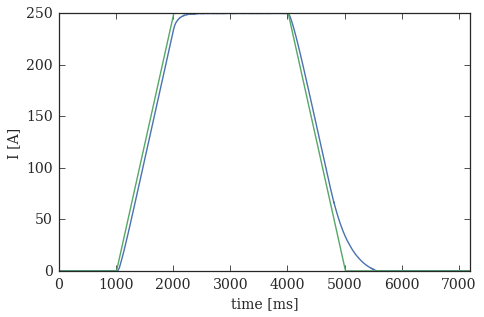

In [81]:
# check the content of a single file
myFileFormat=myToolbox.japcMatlabImport(myFiles[0])
plt.plot(myFileFormat.RPPBK_BA5_BBLR5177M.LOG_OASIS_I_MEAS.value.DATA)
plt.plot(myFileFormat.RPPBK_BA5_BBLR5177M.LOG_OASIS_I_REF.value.DATA)

plt.xlabel('time [ms]')
plt.ylabel('I [A]')
plt.axis('tight')

In [82]:
myFileFormat.parameters

array([u'SPS.BCTDC.41435/Acquisition', u'SPSBQSB1/Acquisition',
       u'SPSBQSB1/SamplerAcquisition',
       u'RPPBK.BA5.BBLR5177M/LOG.OASIS.I_REF',
       u'RPPBK.BA5.BBLR5177M/LOG.OASIS.I_MEAS'], dtype=object)

In [83]:
# import all the selected file and variables in a dataFrame
MD1949=myToolbox.fromMatlabToDataFrame(myFiles,['RPPBK_BA5_BBLR5177M.LOG_OASIS_I_MEAS.value.DATA'])
MD1949.head()

,cycleStamp,matlabPLS,matlabFilePath,RPPBK_BA5_BBLR5177M.LOG_OASIS_I_MEAS.value.DATA
2016-11-17 11:52:26.535,1.479384e+18,SPS.USER.MD2,/eos/user/s/sterbini/MD_ANALYSIS/2016/MD1949/2...,"[0.0566483, 0.0230789, 0.0146866, 0.0314713, 0..."
2016-11-17 11:53:12.135,1.479384e+18,SPS.USER.MD2,/eos/user/s/sterbini/MD_ANALYSIS/2016/MD1949/2...,"[0.0230789, 0.0482559, 0.0314713, 0.0314713, 0..."
2016-11-17 11:53:57.735,1.479384e+18,SPS.USER.MD2,/eos/user/s/sterbini/MD_ANALYSIS/2016/MD1949/2...,"[0.0314713, 0.0314713, 0.0314713, 0.0482559, 0..."
2016-11-17 11:54:43.335,1.479384e+18,SPS.USER.MD2,/eos/user/s/sterbini/MD_ANALYSIS/2016/MD1949/2...,"[0.0482559, 0.0482559, 0.0398636, 0.0398636, 0..."
2016-11-17 11:55:28.935,1.479384e+18,SPS.USER.MD2,/eos/user/s/sterbini/MD_ANALYSIS/2016/MD1949/2...,"[0.0482559, 0.0566483, 0.0230789, 0.0230789, 0..."


In [84]:
# we can add in second time additional variable from Matlab files 
myToolbox.addToDataFrameFromMatlab(MD1949,['SPS_BCTDC_41435.Acquisition.value.totalIntensity'])
MD1949.head()

,cycleStamp,matlabPLS,matlabFilePath,RPPBK_BA5_BBLR5177M.LOG_OASIS_I_MEAS.value.DATA,SPS_BCTDC_41435.Acquisition.value.totalIntensity
2016-11-17 11:52:26.535,1.479384e+18,SPS.USER.MD2,/eos/user/s/sterbini/MD_ANALYSIS/2016/MD1949/2...,"[0.0566483, 0.0230789, 0.0146866, 0.0314713, 0...","[1055.46, 1044.03, 1041.89, 1040.46, 1040.46, ..."
2016-11-17 11:53:12.135,1.479384e+18,SPS.USER.MD2,/eos/user/s/sterbini/MD_ANALYSIS/2016/MD1949/2...,"[0.0230789, 0.0482559, 0.0314713, 0.0314713, 0...","[1173.37, 1157.65, 1154.79, 1156.22, 1154.79, ..."
2016-11-17 11:53:57.735,1.479384e+18,SPS.USER.MD2,/eos/user/s/sterbini/MD_ANALYSIS/2016/MD1949/2...,"[0.0314713, 0.0314713, 0.0314713, 0.0482559, 0...","[1004.73, 994.009, 991.865, 990.436, 989.721, ..."
2016-11-17 11:54:43.335,1.479384e+18,SPS.USER.MD2,/eos/user/s/sterbini/MD_ANALYSIS/2016/MD1949/2...,"[0.0482559, 0.0482559, 0.0398636, 0.0398636, 0...","[1089.05, 1078.33, 1074.76, 1074.76, 1073.33, ..."
2016-11-17 11:55:28.935,1.479384e+18,SPS.USER.MD2,/eos/user/s/sterbini/MD_ANALYSIS/2016/MD1949/2...,"[0.0482559, 0.0566483, 0.0230789, 0.0230789, 0...","[931.838, 923.978, 920.405, 921.834, 920.405, ..."


Starting from this generic data frame we can use the method describe above to complete the information using CALS data.